In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from Load_from_postgres import load_data

In [2]:
# Load data from PostgreSQL
data = load_data()

# Check if data was loaded successfully
if data is not None:
    print("Data loaded successfully!")
    data.head() # Display the first few rows of the DataFrame
else:
    print("Failed to load data.")

Data loaded successfully!


In [3]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


data.isnull().sum()

In [4]:
def fill_missing_values(Data):
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]):
            # Fill numeric columns with the mean
            mean_value = data[column].mean()
            data[column].fillna(mean_value, inplace=True)
        else:
            # Fill non-numeric columns with the mode
            mode_value = data[column].mode()[0]  # Get the first mode
            data[column].fillna(mode_value, inplace=True)

# Apply the function
fill_missing_values(data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5556\724285368.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(mean_value, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5556\724285368.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [5]:
data.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [6]:

# Aggregate session frequency, duration, and total traffic per customer
user_engagement = data.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Total session duration
    'Total DL (Bytes)': 'sum',  # Total downloaded data
    'Total UL (Bytes)': 'sum',  # Total uploaded data
}).reset_index()

# Total traffic (DL + UL)
user_engagement['Total Traffic'] = user_engagement['Total DL (Bytes)'] + user_engagement['Total UL (Bytes)']

# Calculate session frequency (assumed to be the count of sessions per user)
user_engagement['Session Frequency'] = data.groupby('MSISDN/Number')['Bearer Id'].count().values

user_engagement.head()



,MSISDN/Number,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Total Traffic,Session Frequency
0,3.360100e+10,116720.0,8.426375e+08,36053108.0,8.786906e+08,1
1,3.360100e+10,181230.0,1.207552e+08,36104459.0,1.568596e+08,1
2,3.360100e+10,134969.0,5.566597e+08,39306820.0,5.959665e+08,1
3,3.360101e+10,49878.0,4.019932e+08,20327526.0,4.223207e+08,1
4,3.360101e+10,37104.0,1.363130e+09,94280527.0,1.457411e+09,2


In [7]:
# Normalize the data for clustering
scaler = StandardScaler()
engagement_metrics = user_engagement[['Session Frequency', 'Dur. (ms)', 'Total Traffic']]
engagement_metrics_scaled = scaler.fit_transform(engagement_metrics)

# Apply K-means clustering (k=5)
kmeans = KMeans(n_clusters=5, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(engagement_metrics_scaled)

# View cluster assignments
user_engagement.head()


,MSISDN/Number,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Total Traffic,Session Frequency,Cluster
0,3.360100e+10,116720.0,8.426375e+08,36053108.0,8.786906e+08,1,4
1,3.360100e+10,181230.0,1.207552e+08,36104459.0,1.568596e+08,1,4
2,3.360100e+10,134969.0,5.566597e+08,39306820.0,5.959665e+08,1,4
3,3.360101e+10,49878.0,4.019932e+08,20327526.0,4.223207e+08,1,4
4,3.360101e+10,37104.0,1.363130e+09,94280527.0,1.457411e+09,2,4


In [8]:
# Aggregate TCP retransmission, RTT, and throughput per customer
experience_metrics = data.groupby('MSISDN/Number').agg({
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'TCP DL Retrans. Vol (Bytes)': 'sum',
    'TCP UL Retrans. Vol (Bytes)': 'sum',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# View aggregated metrics
experience_metrics.head()


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,3.360100e+10,46.000000,0.000000,2.080991e+07,759658.664811,37.0,39.0
1,3.360100e+10,30.000000,1.000000,2.080991e+07,759658.664811,48.0,51.0
2,3.360100e+10,109.795706,17.662883,2.080991e+07,759658.664811,48.0,49.0
3,3.360101e+10,69.000000,15.000000,1.066000e+03,759658.664811,204.0,44.0
4,3.360101e+10,57.000000,2.500000,3.015954e+07,780860.664811,20197.5,8224.5


In [9]:
# Normalize experience metrics
scaler = StandardScaler()
experience_metrics_scaled = scaler.fit_transform(experience_metrics[['Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)', 'Avg Bearer TP DL (kbps)']])

# Apply K-means clustering (k=2) for experience metrics
kmeans_exp = KMeans(n_clusters=2, random_state=42)
experience_metrics['Cluster'] = kmeans_exp.fit_predict(experience_metrics_scaled)

# View cluster assignments
experience_metrics.head()


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Cluster
0,3.360100e+10,46.000000,0.000000,2.080991e+07,759658.664811,37.0,39.0,0
1,3.360100e+10,30.000000,1.000000,2.080991e+07,759658.664811,48.0,51.0,0
2,3.360100e+10,109.795706,17.662883,2.080991e+07,759658.664811,48.0,49.0,0
3,3.360101e+10,69.000000,15.000000,1.066000e+03,759658.664811,204.0,44.0,0
4,3.360101e+10,57.000000,2.500000,3.015954e+07,780860.664811,20197.5,8224.5,0


In [10]:
experience_metrics.columns

Index(['MSISDN/Number', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'Cluster'],
      dtype='object')

In [11]:
from scipy.spatial.distance import euclidean

# Load previous engagement and experience data
engagement_scores = user_engagement[['MSISDN/Number', 'Session Frequency', 'Dur. (ms)', 'Total Traffic', 'Cluster']]
experience_scores = experience_metrics[['MSISDN/Number', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)', 'Avg Bearer TP DL (kbps)', 'Cluster']]


In [12]:

# Strip any leading/trailing whitespace from column names
engagement_scores.columns = engagement_scores.columns.str.strip()
experience_scores.columns = experience_scores.columns.str.strip()

# Print the column names for debugging
print("Engagement scores columns:", engagement_scores.columns)
print("Experience scores columns:", experience_scores.columns)

# Merge engagement and experience data
engagement_scores = engagement_scores.merge(experience_scores, on='MSISDN/Number', how='inner')

# Check the merged columns after merge
print("Merged DataFrame columns:", engagement_scores.columns)

# Define the calculation function
def calculate_score(row, cluster_metrics):
    min_engagement = cluster_metrics['Session Frequency'].loc['min']
    max_experience = cluster_metrics['Avg RTT DL (ms)'].loc['max']
    avg_bearer_tp_dl_min = cluster_metrics['Avg Bearer TP DL (kbps)'].loc['min']

    return euclidean(
        [row['Session Frequency'], row['Avg RTT DL (ms)'], row['Avg Bearer TP DL (kbps)']], 
        [min_engagement, max_experience, avg_bearer_tp_dl_min]
    )



Engagement scores columns: Index(['MSISDN/Number', 'Session Frequency', 'Dur. (ms)', 'Total Traffic',
       'Cluster'],
      dtype='object')
Experience scores columns: Index(['MSISDN/Number', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'Avg Bearer TP DL (kbps)', 'Cluster'],
      dtype='object')
Merged DataFrame columns: Index(['MSISDN/Number', 'Session Frequency', 'Dur. (ms)', 'Total Traffic',
       'Cluster_x', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'Avg Bearer TP DL (kbps)', 'Cluster_y'],
      dtype='object')


In [13]:
# Example cluster metrics
cluster_metrics = {
    'Session Frequency': engagement_metrics['Session Frequency'].describe(),
    'Avg RTT DL (ms)': experience_metrics['Avg RTT DL (ms)'].describe(),
    'Avg Bearer TP DL (kbps)': experience_metrics['Avg Bearer TP DL (kbps)'].describe(),
}

# Assign satisfaction scores
engagement_scores['Satisfaction Score'] = engagement_scores.apply(lambda row: calculate_score(row, cluster_metrics), axis=1)



In [14]:
# Top 10 satisfied customers
top_10_satisfaction = engagement_scores.nlargest(10, 'Satisfaction Score')

print("Top 10 satisfied customers:")
print(top_10_satisfaction[['MSISDN/Number', 'Satisfaction Score']])


Top 10 satisfied customers:
        MSISDN/Number  Satisfaction Score
49595    3.366268e+10       281642.590005
37838    3.365991e+10       263786.296219
14564    3.362795e+10       255577.657822
60763    3.366566e+10       249637.651329
27722    3.365148e+10       245003.822723
92374    3.376033e+10       243533.990437
98280    3.376267e+10       243341.878568
104697   3.378240e+10       239221.284379
52298    3.366336e+10       232946.900889
52830    3.366349e+10       230965.326575


## changing the Satisfactory Score from thier perspective value to rating to 1-5 scale

In [15]:
import numpy as np


min_score = engagement_scores['Satisfaction Score'].min()
max_score = engagement_scores['Satisfaction Score'].max()

# Function to normalize and map to a 1-5 scale
def convert_to_rating(score, min_score, max_score):
    # Normalize the score to a 0-1 range
    normalized_score = (score - min_score) / (max_score - min_score)
    
    # Map normalized score to a 1-5 scale
    rating = 1 + normalized_score * 4  # Scale to 1-5
    
    return round(rating, 2)  # Round to two decimal places or use round(rating) for whole numbers

# Apply the rating conversion
engagement_scores['Rating'] = engagement_scores['Satisfaction Score'].apply(lambda x: convert_to_rating(x, min_score, max_score))



In [16]:

# Output the top 10 satisfied customers with their ratings
top_10_ratings = engagement_scores.nlargest(10, 'Rating')
print("Top 10 satisfied customers (Rating 1-5):")
print(top_10_ratings[['MSISDN/Number', 'Satisfaction Score', 'Rating']])

Top 10 satisfied customers (Rating 1-5):
        MSISDN/Number  Satisfaction Score  Rating
49595    3.366268e+10       281642.590005    5.00
37838    3.365991e+10       263786.296219    4.75
14564    3.362795e+10       255577.657822    4.63
60763    3.366566e+10       249637.651329    4.55
27722    3.365148e+10       245003.822723    4.48
92374    3.376033e+10       243533.990437    4.46
98280    3.376267e+10       243341.878568    4.46
104697   3.378240e+10       239221.284379    4.40
52298    3.366336e+10       232946.900889    4.31
52830    3.366349e+10       230965.326575    4.28


In [17]:
engagement_scores['Rating'].tail()

106852    2.38
106853    2.39
106854    2.37
106855    2.37
106856    2.37
Name: Rating, dtype: float64

In [18]:
# Building the Regression Model
# Feature ENgineering

In [19]:
engagement_scores['Traffic per Session'] = engagement_scores['Total Traffic'] / engagement_scores['Session Frequency']
engagement_scores['Engagement Duration Ratio'] = engagement_scores['Dur. (ms)'] / engagement_scores['Session Frequency']


In [20]:
engagement_scores.head()

,MSISDN/Number,Session Frequency,Dur. (ms),Total Traffic,Cluster_x,Avg RTT DL (ms),TCP DL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Cluster_y,Satisfaction Score,Rating,Traffic per Session,Engagement Duration Ratio
0,3.360100e+10,1,116720.0,8.786906e+08,4,46.000000,2.080991e+07,37.0,0,96877.007066,2.38,878690574.0,116720.0
1,3.360100e+10,1,181230.0,1.568596e+08,4,30.000000,2.080991e+07,48.0,0,96893.011889,2.38,156859643.0,181230.0
2,3.360100e+10,1,134969.0,5.959665e+08,4,109.795706,2.080991e+07,48.0,0,96813.216193,2.37,595966483.0,134969.0
3,3.360101e+10,1,49878.0,4.223207e+08,4,69.000000,1.066000e+03,204.0,0,96854.214839,2.38,422320698.0,49878.0
4,3.360101e+10,2,37104.0,1.457411e+09,4,57.000000,3.015954e+07,20197.5,0,98949.284804,2.41,728705472.0,18552.0


In [21]:
engagement_scores.columns

Index(['MSISDN/Number', 'Session Frequency', 'Dur. (ms)', 'Total Traffic',
       'Cluster_x', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'Avg Bearer TP DL (kbps)', 'Cluster_y', 'Satisfaction Score', 'Rating',
       'Traffic per Session', 'Engagement Duration Ratio'],
      dtype='object')

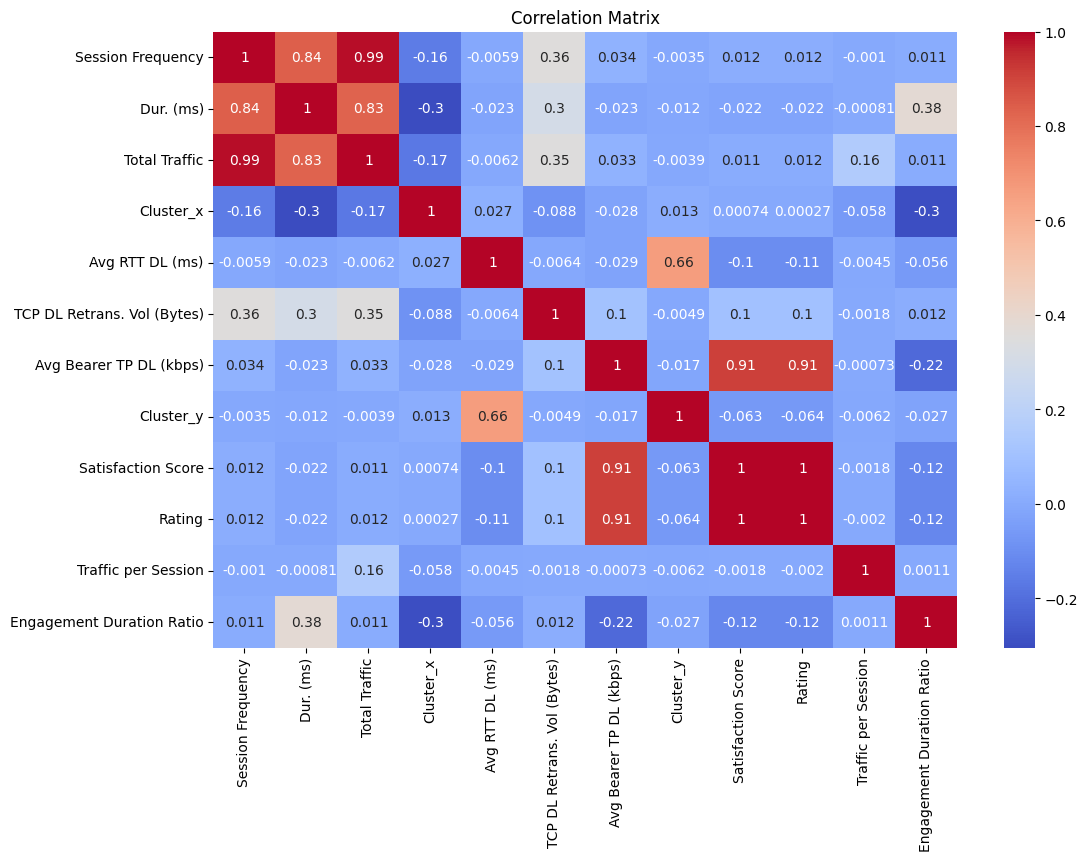

In [22]:
# Correlation Analysis
correlation_columns=['Session Frequency', 'Dur. (ms)', 'Total Traffic',
       'Cluster_x', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'Avg Bearer TP DL (kbps)', 'Cluster_y', 'Satisfaction Score', 'Rating',
       'Traffic per Session', 'Engagement Duration Ratio']

plt.figure(figsize=(12, 8))
correlation_matrix = engagement_scores[correlation_columns].corr()
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score


# Feature Engineering
engagement_scores['Traffic per Session'] = engagement_scores['Total Traffic'] / engagement_scores['Session Frequency']
engagement_scores['Engagement Duration Ratio'] = engagement_scores['Dur. (ms)'] / engagement_scores['Session Frequency']



In [40]:
# Define features and target
features = engagement_scores[['Dur. (ms)', 'Total Traffic', 'Traffic per Session', 'Engagement Duration Ratio','Avg Bearer TP DL (kbps)','Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)']]
target = engagement_scores['Satisfaction Score']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_scaled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_poly, target, test_size=0.2, random_state=42)



In [41]:
# Build and train the models
# Using Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)




In [42]:
# Evaluate Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
cv_scores_lr = cross_val_score(model_lr, features_poly, target, cv=5, scoring='r2')





In [43]:
# Print results
print("Linear Regression Results:")
print(f"Mean Squared Error: {mse_lr}")
print(f"R^2 Score: {r2_lr}")
print(f"Cross-validated R² score: {cv_scores_lr.mean()}")



Linear Regression Results:
Mean Squared Error: 313515.7041295222
R^2 Score: 0.9940144791125282
Cross-validated R² score: -41.916092873804594


### K-Means Clustering

In [45]:
# Merge engagement and experience scores
final_scores = engagement_scores.merge(experience_scores, on='MSISDN/Number', suffixes=('_eng', '_exp'))
final_scores['Engagement Score'] = engagement_scores['Satisfaction Score']
final_scores['Experience Score'] = experience_scores['Avg RTT DL (ms)']



In [46]:
# Normalize scores for clustering
scores_scaled = StandardScaler().fit_transform(final_scores[['Engagement Score', 'Experience Score']])

# Apply k-means clustering (k=2)
kmeans_final = KMeans(n_clusters=2, random_state=42)
final_scores['Cluster'] = kmeans_final.fit_predict(scores_scaled)


In [47]:

# Cluster metrics
cluster_summary_final = final_scores.groupby('Cluster').agg({
    'Engagement Score': ['mean', 'std'],
    'Experience Score': ['mean', 'std']
}).reset_index()

cluster_summary_final


Cluster Engagement Score              Experience Score             
                      mean          std             mean          std
0       0     99394.109624  7453.639155       103.588801   250.855247
1       1     86740.109138  9573.369666     10346.140986  9477.958736

In [49]:
engagement_scores.to_csv('A:/10x/10X_Acadamy/Data\Data_saved/engagement_scores.csv', index=False)
experience_scores.to_csv('A:/10x/10X_Acadamy/Data\Data_saved/experience_scores.csv', index=False)

print("DataFrames saved as CSV files.")

DataFrames saved as CSV files.
